# CxC Datathon 2024 - Infinite Investment Systems Ltd - Churn Prediction and Analysis
## By: Jaden Noronha

For this challenge, I was tasked with developing a Machine Learning model for a growing wealth management platform to predict customer churn. After using this model to predict which customer will churn, I have to develop a marketing strategy to prevent these customers from churning. 

Churning is when a customer leaves/unsubscribes/stops using a service. As this wealth management platform wants to continue their growth, developing models and strategies that can accurately predict customer churn and prevent it is crucial.

This Notebook will be broken into two parts:
- Part 1: Developing the Churn Prediction Model
- Part 2: Analyzing the churning customers to determine trends and develop strategies.

## Part 1: Developing the Churn Prediction Model
We were provided with the following data files:
- history.csv: the history of a selection of our customers with a "label" column indicating if they churned out of our platform. this file will be used for training, testing and validating our model.
- test.csv: the customers that we want to predict if they will churn.
- account_data_info.csv: descriptions for some of the columns

To develop this model, we will first do some exploratory analysis, then we will preform feature engineering and data preprocessing on the training data to prep it for training, then we will train the model and tune it, finally we will use our model to predict on the test set.

### Importing Libraries
We will start by importing the libraries we will be using:

In [1]:
# Import standard Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import datetime for data preprocessing
from datetime import datetime, timedelta

# Import modules for model training and tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings("ignore")

### Exploratory Data Analysis
We will begin by importing our training data:

In [2]:
df = pd.read_csv("data/history.csv")
df.head()

,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,NaN,CAD,t,5.0,C,2022-07-04,18.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,NaN,CAD,t,5.0,A,2018-07-05,16.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn
3,741930,CASH,f,NaN,CAD,t,3.0,T,NaN,12.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
4,1137922,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,NaN,NaN,f,Churn


In [3]:
print("List of columns: %s" % (list(df.columns)))
print("# of columns: %s" % (len(list(df.columns))))

List of columns: ['id', 'type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'class_id', 'debit_code', 'last_trade_date', 'contract_type', 'inception_date', 'net_of_fees', 'cashflows_custody_fee', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'dividend_confirm_code', 'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer', 'spousal_age_flag', 'terminal_code', 'has_mul

As we can see here, our training data contains a wide variety of fields. These fields include binary data (represented as "t" or "f"), categorical data, datetime data (this is currently represented as a string, this will be accounted for later) and numerical data. Let us get a better understanding of the distributions of these columns:

In [4]:
df.info()
# Settings for displaying dataframes
pd.set_option('display.max_columns', 125)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673339 entries, 0 to 673338
Columns: 106 entries, id to label
dtypes: float64(21), int64(1), object(84)
memory usage: 544.5+ MB


In [5]:
df.describe()

,id,class_id,contract_type,cashflows_custody_fee,credit_limit_type,dividend_confirm_code,options_trading_type,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,deceased_fair_market_value,target_grantor_grantee_flag,esir_number,portfolio_cost_method,portfolio_name_address_option,portfolio_report_option,portfolio_summary_option,interactive_portfolio_code,mailing_consent,number_of_beneficiaries,resp_specimen_plan
count,6.733390e+05,670141.000000,577516.000000,0.0,670141.000000,670141.000000,670141.000000,670141.0,670141.000000,670141.000000,670141.000000,670141.000000,168463.000000,1.200000e+01,670141.0,670141.0,670141.000000,670141.0,670141.0,670141.000000,356354.000000,2.272100e+04
mean,1.123983e+06,4.439299,14.291886,NaN,0.000640,0.080592,0.054214,0.0,0.032205,0.002332,1.150804,2.183194,0.154693,8.049136e+05,0.0,0.0,0.000028,0.0,0.0,0.006687,0.112865,1.017617e+06
std,9.681361e+05,3.122250,4.381705,NaN,0.074733,0.744678,0.356843,0.0,1.785295,0.048238,1.019132,46.430533,0.663287,3.745883e+05,0.0,0.0,0.009696,0.0,0.0,0.081498,0.483747,3.040427e+04
min,2.200000e+01,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,9.250800e+04,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.008002e+06
25%,7.438955e+05,3.000000,12.000000,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,7.593092e+05,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.008002e+06
50%,9.543410e+05,5.000000,17.000000,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,0.000000,0.000000,1.003572e+06,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.008002e+06
75%,1.164738e+06,5.000000,18.000000,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,0.000000,0.000000,1.018264e+06,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.008003e+06
max,6.891117e+06,75.000000,18.000000,NaN,9.000000,9.000000,7.000000,0.0,99.000000,1.000000,3.000000,3493.740000,3.000000,1.058312e+06,0.0,0.0,4.000000,0.0,0.0,1.000000,24.000000,1.114002e+06


From this view, we can see that we are primarily working with floating point numbers, integers and generic objects (represented as strings). To handle strings, we need to feature engineer some columns, which will be done after.

From the second table, we notice that some columns are completely empty (or filled with null values), such as cashflows_custody_fee. Let us count the number of null values in the dataset:

In [6]:
null_counts = pd.DataFrame(df.isnull().sum()).reset_index()
null_counts.columns = ["category", "count"]
null_counts.sort_values("count", ascending=False).transpose()

,12,53,87,59,3,29,26,28,60,57,98,66,23,56,54,90,50,68,103,94,95,89,93,91,88,86,92,97,102,20,96,22,21,8,58,77,78,70,69,9,47,51,84,55,16,33,73,24,30,67,31,64,63,62,61,6,32,7,34,25,85,19,49,27,52,10,1,101,82,99,104,81,80,100,79,83,0,76,38,2,4,5,11,13,14,15,17,18,35,36,37,39,75,40,41,42,43,44,45,46,48,65,71,72,74,105
category,cashflows_custody_fee,esir_number,special_fee_code,function_code,country_code,sss_agent,sss_location,sss_type,tms_settlement_location,conjunction,resp_specimen_plan,loan_limit_override,arp_pension_origin,special_tag,shareholder_language,plan_end_date,target_grantor_grantee_flag,non_plan_book_value_flag,retail_last_maintenance_user,use_original_date_for_payment_calc,is_family_resp,plan_effective_date,rrif_original_date,is_resp,non_calendar_year_end,is_pledged,number_of_beneficiaries,is_plan_grandfathered,retail_last_maintenance_time,retail_plan,is_hrdc_resp,is_arp_locked,is_spousal,last_trade_date,title,risk_tolerance,investment_objective,last_update_date,has_discrete_auth,contract_type,terminal_code,discretionary_trading_authorized,last_maintenance_time,dup_trip_quad_code,branch,interest_dividend_conversion_type,mailing_consent,language_code,is_midwest_clearing_account,interactive_portfolio_code,rep_commission_rate,portfolio_summary_option,portfolio_report_option,portfolio_name_address_option,portfolio_cost_method,class_id,rep_commission_override,debit_code,guarantee_gtor_type,dividend_confirm_code,last_maintenance_user,credit_limit_type,deceased_fair_market_value,options_trading_type,iso_funds_code,inception_date,type_code,is_olob,is_control_account,inserted_at,visible_in_reports,is_gl_account,is_inventory_account,updated_at,is_broker_account,is_extract_eligible,id,has_received_instruction,shareholder_instructions_received,is_registered,currency_code,is_active,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,include_client_consolidation,use_client_address,use_hand_delivery,use_mail,share_name_address_to_issuer,rrsp_limit_reached,consent_to_email_delivery,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,has_multiple_name,receive_general_mailings,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,consent_to_pay_for_mail,label
count,673339,673327,673271,669102,669050,668273,668258,668258,665590,657891,650618,642194,632725,626904,623554,517718,504876,368978,317118,316985,316985,316985,316985,316985,316985,316985,316985,316985,316985,316985,316985,313694,313694,307875,186266,145530,145453,111327,96045,95823,77413,76123,3538,3210,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,3198,237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Yikes. We see that a significant number of columns are mostly null. From df.describe, there are 673339 entries in the dataset. We note that 504876 (# of nulls for target_grantor_grantee_flag) is almost 75% of the dataframe. Also, there is a large section of columns with about 50% of its values null.

### Data Preprocessing
We will first drop columns from the dataset with over 70% of its values null. If we were to use these columns, we run the risk of having skewed or biased results, as we do not know the exact values for those users.

In [7]:
step1 = list(null_counts[null_counts["count"] >= 0.7 * len(df)]["category"])
step1_df = df.drop(step1, axis=1)
step1_df.head()

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,inception_date,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,branch,include_client_consolidation,use_client_address,credit_limit_type,retail_plan,is_spousal,is_arp_locked,language_code,dividend_confirm_code,options_trading_type,is_midwest_clearing_account,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,use_hand_delivery,use_mail,share_name_address_to_issuer,shareholder_instructions_received,rrsp_limit_reached,is_portfolio_account,has_no_min_commission,is_tms_eligible,is_agent_bbs_participant,is_parameters_account,is_spousal_transfer,spousal_age_flag,terminal_code,has_multiple_name,deceased_fair_market_value,discretionary_trading_authorized,iso_funds_code,dup_trip_quad_code,title,portfolio_cost_method,portfolio_name_address_option,portfolio_report_option,portfolio_summary_option,receive_general_mailings,interactive_portfolio_code,non_plan_book_value_flag,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,mailing_consent,consent_to_pay_for_mail,consent_to_email_delivery,has_received_instruction,risk_tolerance,investment_objective,is_broker_account,is_inventory_account,is_gl_account,is_control_account,is_extract_eligible,last_maintenance_time,last_maintenance_user,is_pledged,non_calendar_year_end,plan_effective_date,is_resp,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,is_plan_grandfathered,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,CAD,t,3.0,0,NaN,NaN,2017-08-18,f,f,f,f,IAVM,t,f,0.0,NaN,NaN,NaN,E,0.0,0.0,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,NaN,f,0.0,f,CAD,A,NaN,0.0,0.0,0.0,0.0,t,0.0,V,f,NaN,f,f,0.0,f,f,f,NaN,NaN,f,f,f,f,t,2021-12-16 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,CAD,t,5.0,C,2022-07-04,18.0,2018-11-08,f,f,f,f,IAVM,t,t,0.0,RI,f,f,E,0.0,0.0,False,0.0,0.0,0.0,2.0,f,f,t,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,f,CAD,A,MR,0.0,0.0,0.0,0.0,t,0.0,NaN,f,2022-09-08,t,f,0.0,f,f,t,H10M90,B05G85S10,f,f,f,f,t,2023-01-03 00:00:00,BATCH,f,0000,2018-11-08,f,0.0,2018-11-08,f,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,2018-07-05,16.0,2009-04-08,f,f,f,f,IAVM,f,f,0.0,RS,t,f,F,0.0,0.0,False,0.0,0.0,0.0,2.0,f,f,t,f,f,f,f,f,f,f,f,f,G023,f,0.0,f,CAD,A,MADAME,0.0,0.0,0.0,0.0,t,0.0,NaN,f,2014-04-23,f,t,0.0,t,f,t,H50M50S00,G50S50,f,f,f,f,t,2021-03-15 00:00:00,GUERINO,f,00/0,2009-04-08,f,0.0,2009-04-08,f,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,NaN,12.0,2021-01-04,f,f,f,f,IAVM,t,t,0.0,NaN,NaN,NaN,E,0.0,0.0,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,113C,f,0.0,f,CAD,A,NaN,0.0,0.0,0.0,0.0,t,0.0,V,f,2021-01-04,t,f,0.0,f,f,t,M99,G99,f,f,f,f,t,2021-01-04 00:00:00,T80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,NaN,17.0,2017-07-21,f,f,f,f,IAVM,t,f,0.0,NaN,NaN,NaN,E,0.0,0.0,False,0.0,0.0,0.0,0.0,f,f,t,f,f,f,f,f,f,f,f,f,BATCH,f,0.0,f,CAD,A,MRS,0.0,0.0,0.0,0.0,t,0.0,V,NaN,2017-07-24,f,t,0.0,f,f,t,M99,G99,f,f,f,f,t,2023-06-27 00:00:00,H01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,NaN,NaN,f,Churn


As previously mentioned, a large subset of columns contain about half null values. Let us determine if the same rows contain these null values by counting the null values for rows where retail_last_maintenance_user (~47% null) is null:

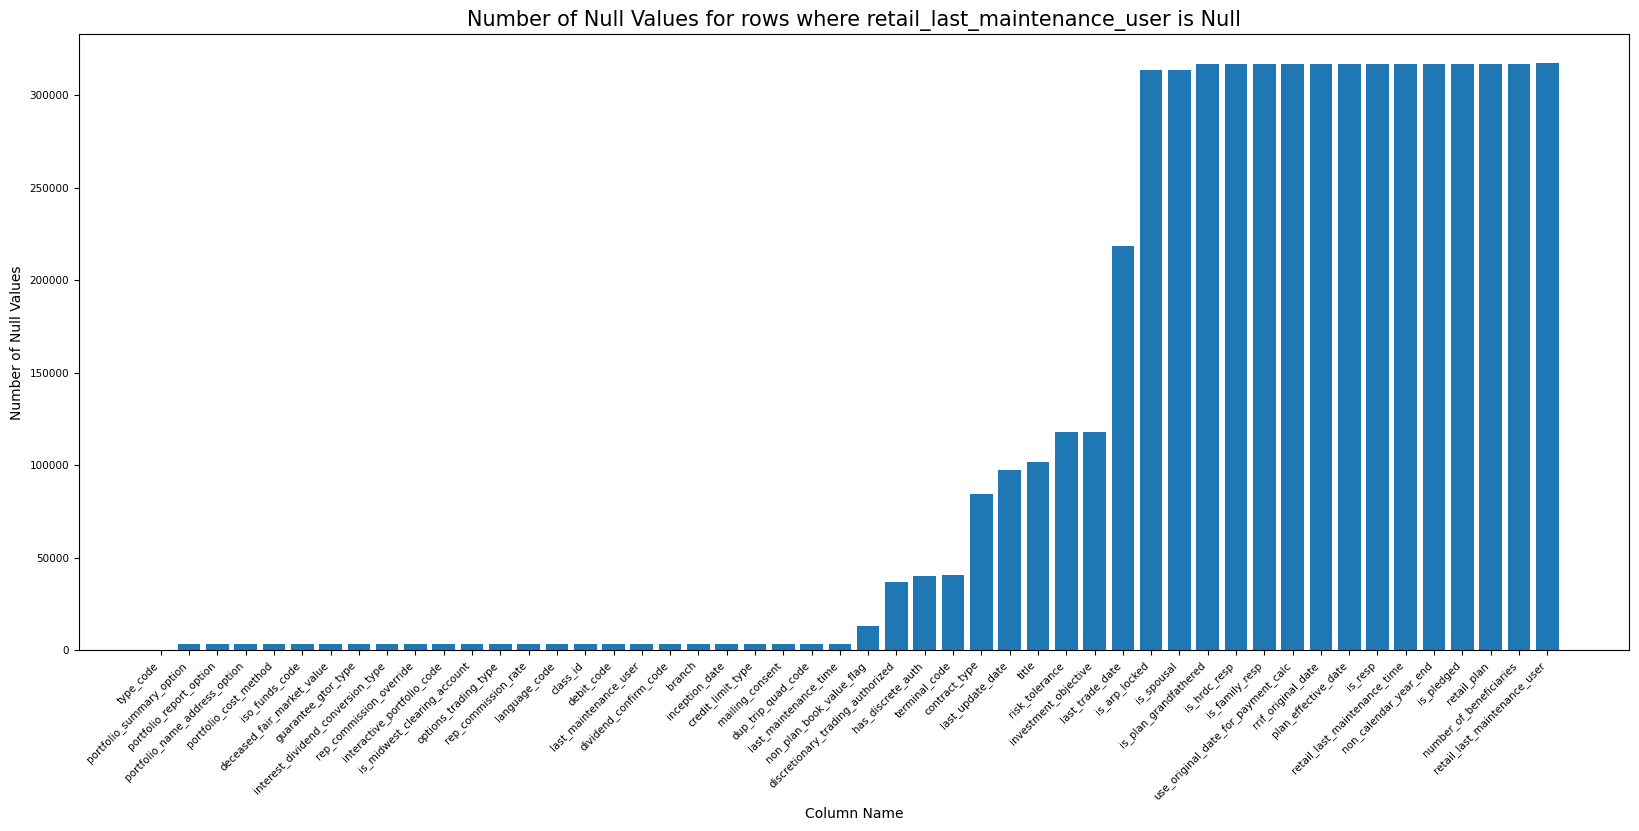

In [8]:
null_test = step1_df[step1_df["retail_last_maintenance_user"].isnull()]
test_df = pd.DataFrame(null_test.isna().sum().reset_index())
test_df.columns = ["Column Name", "# of Null values"]
test_df = test_df[~(test_df["# of Null values"] == 0)]
test_df = test_df.sort_values("# of Null values")

plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 7.5
plt.title("Number of Null Values for rows where retail_last_maintenance_user is Null", fontsize=15)
plt.xlabel("Column Name", fontsize=10)
plt.ylabel("Number of Null Values", fontsize=10)
plt.bar(test_df["Column Name"],test_df["# of Null values"])
plt.xticks(rotation=45, ha='right')
plt.show()

This indicates that a specific subset of columns might have a recording error where these values are all null. While some of these values may be inferred based off other columns or filled in based on the non-null values in the same column, it is best not to include these rows. A recording error might have an unknown impact on the validity of the data. Including this may skew the data significantly, resulting in a biased and flawed model. Let us drop these rows, then count the number of null values remaining, as well as the number of distinct values in each column.

In [9]:
step2_df = step1_df[~(step1_df["retail_last_maintenance_user"].isnull())].reset_index()
graph_step2 = pd.DataFrame(step2_df.isna().sum().reset_index().sort_values("index"))
graph_step2["distinct"] = graph_step2["index"].apply(lambda x: len(step2_df[x].value_counts()))
graph_step2.columns = ["index", "null count", "distinct"]
graph_step2.sort_values("distinct").transpose()


,11,55,82,54,28,38,66,49,69,14,68,67,25,85,39,37,50,35,18,52,56,13,12,36,47,34,41,26,51,20,3,30,31,17,76,32,40,46,89,22,27,60,53,33,73,88,59,6,62,61,4,45,23,29,43,79,16,63,58,81,80,70,5,21,74,24,15,19,77,2,7,9,48,84,83,72,87,64,65,71,42,44,86,8,57,10,75,78,1,0
index,net_of_fees,non_plan_book_value_flag,is_plan_grandfathered,interactive_portfolio_code,interest_dividend_conversion_type,is_agent_bbs_participant,is_broker_account,portfolio_cost_method,is_control_account,is_fee_exempt,is_gl_account,is_inventory_account,is_midwest_clearing_account,is_olob,is_parameters_account,is_tms_eligible,portfolio_name_address_option,is_portfolio_account,credit_limit_type,portfolio_summary_option,has_discrete_auth,custody_fee_withdrawal,fee_paid_separately,has_no_min_commission,dup_trip_quad_code,rrsp_limit_reached,spousal_age_flag,rep_commission_rate,portfolio_report_option,is_spousal,is_registered,use_hand_delivery,use_mail,use_client_address,is_resp,share_name_address_to_issuer,is_spousal_transfer,iso_funds_code,label,language_code,rep_commission_override,mailing_consent,receive_general_mailings,shareholder_instructions_received,is_pledged,visible_in_reports,is_objecting_to_disclose_info,class_id,consent_to_email_delivery,consent_to_pay_for_mail,currency_code,discretionary_trading_authorized,dividend_confirm_code,guarantee_gtor_type,has_multiple_name,use_original_date_for_payment_calc,include_client_consolidation,has_received_instruction,is_non_objecting_beneficial_owner,is_hrdc_resp,is_family_resp,is_extract_eligible,is_active,is_arp_locked,non_calendar_year_end,options_trading_type,branch,retail_plan,number_of_beneficiaries,type_code,debit_code,contract_type,title,updated_at,inserted_at,last_maintenance_user,retail_last_maintenance_user,risk_tolerance,investment_objective,last_maintenance_time,terminal_code,deceased_fair_market_value,retail_last_maintenance_time,last_trade_date,last_update_date,inception_date,plan_effective_date,rrif_original_date,id,index
null count,0,356187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,11419,84368,0,0,0,0,27765,27643,0,36736,0,0,89541,13710,0,0,0,0,0
distinct,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,6,8,9,13,14,14,17,46,88,105,374,432,702,1166,1349,1403,2125,2898,3946,4682,5500,5520,6716,356221,356221


After dropping, we are left with 356221 rows. As we can see, there are a significant number of columns with only one distinct value. Including these columns could cause significant bias at worst, or provide no meaningful information at best - as a result we should drop these columns. In addition, there are other columns that should be dropped, which are listed below:
- id: used to uniquely identify users, not necessary for churn prediction.
- portfolio_report_option: Grand majority 0.0 (356220/356221), can cause bias
- use_hand_delivery: mostly false (356217/356221), can cause bias
- dividend_confirm_code: mostly 0.0 (356219/356221), can cause bias
- rep_commission_override: mostly 0.0 (356211/356221), can cause bias
- guarantee_gtor_type: mostly 0.0 (356182/356221), can cause bias
- terminal_code: too many distinct categories (1403), can cause overfitting
- retail_last_maintenance_user: too many distinct categories (374), could cause overfitting
- last_maintenance_user: 4too many distinct categories (432), could cause overfitting
- retail_last_maintenance_time: we will be using last_maintenance_time, so this feature is not necessary.
- non_calendar_year_end: contains multiple iterations of zero (0000, 00/0, 0, 0.0), with no clear meaning. Including this feature without proper context might result in an inaccurate model.
- inserted_at: 105 datetimes, one time (2023-05-30 14:20:18) with majority (348716/356221).
- updated_at: similar to inserted_at, however most of the times reside in August 2023

Note that we will be keeping has_discrete_auth despite it containing only one distinct value, as according to the data dictionary, nulls are a valid value for that field. Viewing the data after removing these columns:

In [10]:
step2_drop = list(graph_step2[graph_step2["distinct"] == 1]["index"])
step2_drop.remove("has_discrete_auth")
step2_drop = step2_drop + ["updated_at","inserted_at","retail_last_maintenance_time", "index", "id", "portfolio_report_option", "non_calendar_year_end","use_hand_delivery", "dividend_confirm_code", "retail_last_maintenance_user", "last_maintenance_user","rep_commission_override", "guarantee_gtor_type", "terminal_code"]
step3_df = step2_df.drop(step2_drop,axis=1)

# Settings for displaying dataframes
pd.set_option('display.max_columns', 10)
step3_df.head()

,type_code,is_registered,currency_code,is_active,class_id,...,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,visible_in_reports,label
0,RRIF,t,CAD,t,5.0,...,f,f,f,t,Churn
1,SPOUSAL RRSP,t,CAD,t,5.0,...,f,f,f,f,Churn
2,REG RRSP,t,CAD,t,5.0,...,f,f,f,t,Churn
3,RESP,t,CAD,t,5.0,...,t,t,t,t,Churn
4,TFSA,t,CAD,t,5.0,...,f,f,f,t,Churn


Now that we have removed unnecessary rows and columns, we can begin conducting feature engineering on the remaining data. For future reference, we will save the above DataFrame and a list of its columns.

In [11]:
preprocess_columns = step3_df.columns
train_df = step3_df

### Feature Engineering
Feature Engineering is the act of manipulating existing features in a dataset to develop new features to use in model training. Due to the large amount of data and its variety, feature engineering will ensure that we can get the most out of our model.

We will begin with the type_code column. type_code indicates the type of account. Looking at the value counts below, we see that the main account types are RRSP, TFSA, RRIF, LIRA/LRSP/RLSP, RESP and OFFBOOK. Accounts can also be differentiated if they are spousal. Within our data, is_spousal indicates if the account is spousal, and is_resp/is_family_resp/is_hrdc_resp covers RESP. For the other account types mentioned above, we will make new binary features, where a 1 indicates that an account is of that type and a 0 indicates otherwise. Since type_code covers account types, retail_plan is no longer required, so we can drop that feature.

In [12]:
print("Value counts for type_code")
train_df["type_code"].value_counts()

Value counts for type_code


type_code
REG RRSP          114126
TFSA              107955
RRIF               38861
LIRA/LRSP/RLSP     28271
RESP               22725
SPOUSAL RRSP       21839
OFFBOOK            11976
SPOUSAL RRIF        8975
RDSP                1058
LIRA                 373
CASH SWEEP            40
CASHA                  7
CASH                   5
LIF/RLIF/LRIF          5
Name: count, dtype: int64

In [13]:
def type_code(df):
    """
    is_spousal covers spousal accounts
    is_resp, is_family_resp, is_hrdc_resp covers resps
    As we have other columns to identify the account type, retail_plan is not required (redundant)
    """
    df["is_rrsp"] = df["type_code"].apply(lambda x: pd.notna(x) and "RRSP" in x.upper()).map({True: 1, False: 0})
    df["is_tfsa"] = df["type_code"].apply(lambda x: pd.notna(x) and "TFSA" in x.upper()).map({True: 1, False: 0})
    df["is_lira_lrsp_rlsp"] = df["type_code"].apply(lambda x: pd.notna(x) and ("LIRA" in x.upper() or "LRSP" in x.upper() or "RLSP" in x.upper())).map({True: 1, False: 0})
    df["is_offbook"] = df["type_code"].apply(lambda x: not (pd.notna(x)) or "OFFBOOK" in x.upper()).map({True: 1, False: 0})
    df["is_rrif"] = df["type_code"].apply(lambda x: pd.notna(x) and "RRIF" in x.upper()).map({True: 1, False: 0})
    df["is_spousal"] = df["is_spousal"].map({"t": 1, "f": 0})
    df["is_family_resp"] = df["is_family_resp"].map({"t": 1, "f": 0})
    df["is_hrdc_resp"] = df["is_hrdc_resp"].map({"t": 1, "f": 0})
    df["is_resp"] = df["is_resp"].map({"t": 1, "f": 0})
    df["type_code_other"] = ((df["is_rrsp"] + df["is_tfsa"] + df["is_lira_lrsp_rlsp"] + df["is_offbook"] + df["is_rrif"] + df["is_resp"]) == 0).map({True: 1, False: 0})
    df = df.drop(["type_code", "retail_plan"], axis=1)
    return df

Many of the columns in are data are binary, however they are listed as "t" or "f". We will convert these values into 1 and 0 respectively. Any null values will be replaced with the mode in the dataset.

In [14]:
def binary_cols(df, reference):
    """
    Convert all columns that are t or f to 0 and 1
    """
    binary_cols = ["is_registered","is_active", "include_client_consolidation", "use_client_address", "is_arp_locked", "use_mail", "share_name_address_to_issuer", "shareholder_instructions_received", "is_spousal_transfer", "has_multiple_name", "discretionary_trading_authorized", "receive_general_mailings", "has_discrete_auth", "is_non_objecting_beneficial_owner", "is_objecting_to_disclose_info",  "consent_to_pay_for_mail", "consent_to_email_delivery", "has_received_instruction", "is_extract_eligible", "is_pledged", "use_original_date_for_payment_calc", "visible_in_reports"]
    for col in binary_cols:
        df[col] = df[col].fillna(reference[col].mode()[0]).map({"t": 1, "f": 0})

For the currency_code column, our training data contains either "CAD", or "USD". We will convert these columns into binary columns.

In [15]:
def currency_code(df):
    """
    Convert currency_code column from CAD and USD into separate columns
    """
    df["currency_code_CAD"] = (df["currency_code"] == "CAD").map({True:1,False:0})
    df["currency_code_USD"] = (df["currency_code"] == "USD").map({True:1,False:0})
    df = df.drop(["currency_code"], axis=1)
    return df

The contract_type column represents the shareholder information values according to SHLDR 54-101. The valid values are 07, 09, 10, 12, 17 and 18. However, we notice that there are a lot of values in our data set that are not in this range. This indicates that the values we have in file either have errors, or are out of date and based on an old standard. Thus, we will group these features into an "error" column.

In [16]:
print("Value counts for contract_type")
train_df["contract_type"].value_counts()

Value counts for contract_type


contract_type
17.0    108088
18.0     93777
12.0     43002
9.0      41896
16.0     21085
7.0      12760
10.0     10864
8.0       9074
0.0       2339
11.0      1867
6.0         12
15.0        10
3.0          8
4.0          6
1.0          5
14.0         5
5.0          4
Name: count, dtype: int64

In [17]:
def contract_type(df):
    """
    Based on SHLDR 54-101 form
    """
    df["SHLDR_07"] = (df["contract_type"] == 7.0).map({True:1,False:0})
    df["SHLDR_09"] = (df["contract_type"] == 9.0).map({True:1,False:0})
    df["SHLDR_10"] = (df["contract_type"] == 10.0).map({True:1,False:0})
    df["SHLDR_12"] = (df["contract_type"] == 12.0).map({True:1,False:0})
    df["SHLDR_17"] = (df["contract_type"] == 17.0).map({True:1,False:0})
    df["SHLDR_18"] = (df["contract_type"] == 18.0).map({True:1,False:0})
    df["SHLDR_ERR"] = (df["SHLDR_07"] + df["SHLDR_09"] + df["SHLDR_10"] + df["SHLDR_12"] + df["SHLDR_17"] + df["SHLDR_18"] == 0).map({True:1,False:0})
    df = df.drop(["contract_type"], axis=1)
    return df

The class_id column only has 5.0 and 3.0 as values. Since these represent classes, we will consider 5 and 3 as unique classes and create columns for them.

In [18]:
def class_id(df):
    """
    Convert class_id into columns
    """
    df["class_5"] = (df["class_id"] == 5.0).map({True:1,False:0})
    df["class_3"] = (df["class_id"] == 3.0).map({True:1,False:0})
    df = df.drop(["class_id"], axis=1)
    return df

debit_code represents the Debit interest method based on ISM ACF. According to the data dictionary, 0 represents None, 1 represents normal and all other letters and numbers represent special cases. However in our data, we have predominantly C and A as our main classes. As a result, we will create columns based on whether a debit code is class C, A, 0 or 1.

In [19]:
print("Value counts for debit_code")
train_df["debit_code"].value_counts()

Value counts for debit_code


debit_code
C    214505
A    140965
R       318
0       295
N        45
T        32
5        22
Y        13
M        13
S         8
P         2
Z         1
V         1
7         1
Name: count, dtype: int64

In [20]:
def debit_code(df):
    """
    Based on ISM ACF (Automated Customer Account Transfer Service Communication Format) codes. 
    0: None
    1: Normal
    2-9 or A-Z: Special
    The training dataset was predominantly code A and C, thus create new columns for class 0, 1, A, C
    """
    df["debit_0"] = (df["debit_code"] == 0.0).map({True:1,False:0})
    df["debit_1"] = (df["debit_code"] == 1.0).map({True:1,False:0})
    df["debit_A"] = (df["debit_code"] == "A").map({True:1,False:0})
    df["debit_C"] = (df["debit_code"] == "C").map({True:1,False:0})
    df = df.drop(["debit_code"], axis=1)
    return df

The branch column represents which branch location an account resides in. We will create features for the largest 4 branches: IAVM, IAS, HOLIS, BURGEONV. We note that there is a typo with HOLIS for some of the columns (spelt HOLLIS instead), which we will also account for.

In [21]:
print("Value counts for branch")
train_df["branch"].value_counts()

Value counts for branch


branch
IAVM        258964
IAS          52012
HOLIS        38556
BURGEONV      4596
MGI SEC.      1411
FINXO          452
HOLLIS         229
MCFARLAN         1
Name: count, dtype: int64

In [22]:
def branch(df):
    """
    Separate branch column into different columns. Create columns for IAVM IAS, HOLIS, BURGEONV
    (above 1%)
    """
    df[df["branch"] == "HOLLIS"]["branch"] = "HOLIS"
    df["branch_IAVM"] = (df["branch"] == "IAVM").map({True:1,False:0})
    df["branch_IAS"] = (df["branch"] == "IAS").map({True:1,False:0})
    df["branch_HOLIS"] = (df["branch"] == "HOLIS").map({True:1,False:0})
    df["branch_BURGEONV"] = (df["branch"] == "BURGEONV").map({True:1,False:0})
    df = df.drop(["branch"], axis=1)
    return df

language_code represents the language of the account. The values in the column are either E or F (persumably representing English and French), so columns will be made for them.

In [23]:
def language_code(df):
    """
    Separate language code into separate columns
    """
    df["language_E"] = (df["language_code"] == "E").map({True:1,False:0})
    df["language_F"] = (df["language_code"] == "F").map({True:1,False:0})
    df = df.drop(["language_code"], axis=1)
    return df   

options_trading_type indicates whether the client can trade options. The values in the data set are 0 and two, so new columns will be made for these categories.

In [24]:
def options_trading_type(df):
    """
    Separate options_trading_type into columns based on the options a client can trade.
    Include 0.0, 2.0 (other categories too small)
    """
    df["options_type_0"] = (df["options_trading_type"] == 0).map({True:1,False:0})
    df["options_type_2"] = (df["options_trading_type"] == 2).map({True:1,False:0})
    df = df.drop(["options_trading_type"], axis=1)
    return df

deceased_fair_market_value is the value of the plan at death. This data is numerical, and nulls will be filled with the mean.

In [25]:
def deceased_fair_market_value(df, reference):
    """
    fill in non-float and null values in deceased_fair_market_value with mean
    """
    df["deceased_fair_market_value"].fillna(reference["deceased_fair_market_value"].describe()["mean"])
    mkt_val = []
    for val in list(df["deceased_fair_market_value"]):
        try:
            mkt_val.append(float(val))
        except:
            mkt_val.append(reference["deceased_fair_market_value"].describe()["mean"])
    df["deceased_fair_market_value"] = mkt_val

iso_funds_code is either CAD or USD, columns can be created for these values.

In [26]:
def iso_funds_code(df):
    """
    Separate iso_funds_code into separate columns
    """
    df["iso_funds_CAD"] = (df["iso_funds_code"] == "CAD").map({True:1,False:0})
    df["iso_funds_USD"] = (df["iso_funds_code"] == "USD").map({True:1,False:0})
    df = df.drop(["iso_funds_code"], axis=1)
    return df

title contains the preferred greeting for the account holder. We can see that there are a large number of different titles, including masculine, feminine, and gender-neutral titles. From this data, we can group together the titles associated with each type based on how frequently they occur in our training data. We will make two features, one for masculine titles and one for feminine (gender-neutral titles might be lumped in with other titles due to the limited training data, so no feature will be built for those titles).

In [27]:
print("Value counts for title")
train_df["title"].value_counts()

Value counts for title


title
MR                68503
MRS               52236
MR.               36342
MRS.              26798
MS                21003
MADAME            14941
MONSIEUR          14161
MS.                9315
M.                 7722
MME                6581
MLLE               3620
MISS               3519
M                  3315
DR                 2163
DR.                1050
MISS.               215
MME.                186
DOCTEUR              81
MADEMOISELLE         35
MLLE.                12
REV.                  8
REV                   5
DRE                   4
MR HONORABLE          3
MRSS                  3
HON                   3
SIR                   3
MR. MAJOR             3
VEN                   2
4.                    2
MR. HON               2
RABBI                 2
PROFESSOR             2
THE HONOURABLE        1
MX.                   1
LCOL                  1
MSS                   1
(BILL)                1
MM.                   1
MADAME MADAME         1
M ADAM                1
MR HON-CHA

In [28]:
def title(df):
    """
    Separate based on persumed gender
    """
    male = ["MR", "MR.", "MONSIEUR", "M.", "M"]
    female = ["MRS", "MRS.", "MS", "MADAME", "MS.", "MME", "MME.","MLLE", "MISS"]
    male_list = []
    female_list = []
    for item in list(df["title"]):
        if item in male:
            male_list.append(1)
            female_list.append(0)
            continue
        elif item in female:
            male_list.append(0)
            female_list.append(1)
            continue
        else:
            male_list.append(0)
            female_list.append(0)
            continue
    df["title_m"] = male_list
    df["title_f"] = female_list
    df = df.drop(["title"], axis = 1)
    return df

risk_tolerance represents the risk appetite for the customers on the platform. The values are formatted such that the character representing the risk category is followed by a number representing the percentage that risk category takes in the portfolio (adding up to 100%). According to the data dictionary, the categories within the column should be low (L), medium (M), Medium-Higher (Q) and high (H). However, in the training data, we see that most of the values in the column are either H, M, S or L, with a tiny number of entries being Q (24). Through manually inspecting some of the values which contain S, we can conclude that S represents "Small", which should be grouped together with low (L). As a result, we will create features for L/S, M and H.

Null values will be filled with the mode of the dataset, which is M = 100% (the mode was used since it implies that it is the default risk setting for accounts). Some of the values do not have percentages that sum up to 100%, in these cases, we scale the percentage for each category by multiplying it by (100/sum of row).

In [29]:
test_risk = list(step3_df[~(step3_df["risk_tolerance"].isna())]["risk_tolerance"])
letters = dict()
for item in test_risk:
    levels = []
    for char in str(item):
        if char.isalpha():
            if char.upper() in letters.keys():
                letters[char.upper()] = letters[char.upper()]+ 1
            else:
                letters[char.upper()] = 1
print("# of occurences for each category in risk_tolerance: %s" % (letters))
print("Value counts for risk_tolerance")
print(step3_df["risk_tolerance"].value_counts())

# of occurences for each category in risk_tolerance: {'H': 191855, 'M': 307390, 'S': 13298, 'L': 59505, 'Q': 24, 'G': 12, 'E': 4, 'F': 3, 'B': 2, 'N': 1, 'C': 1}
Value counts for risk_tolerance
risk_tolerance
M99             114157
H20M80           36006
H10M90           23181
H99              15659
H30M70           15026
                 ...  
H24L27M49            1
H04L40M56            1
H98L02               1
H05L30M65S00         1
H80L05M15            1
Name: count, Length: 702, dtype: int64


In [30]:
def risk_tolerance(df):
    main_letters = ["H", "M", "S", "L"]
    risk_mode = [0,100,0,0]
    H = []
    M = []
    S = []
    L = []
    for item in list(df["risk_tolerance"]):
        risk_columns = {"H": 0, "M": 0, "S": 0, "L": 0}
        if not (isinstance(item,str)): # if not string, is null
            H.append(0)
            M.append(100)
            S.append(0)
            L.append(0)
        else:
            item_letters = []
            for char in str(item): # find all codes in string
                if (char.isalpha()):
                    item_letters.append(char.upper())
            if [x for x in item_letters if x not in main_letters]: # if any non-main codes, replace with mode
                H.append(0)
                M.append(100)
                S.append(0)
                L.append(0)
            else:
                for code in item_letters: # find percentage associated with each code based on string positions
                    start_pos = str(item).find(code)
                    percent = []
                    for char in str(item[start_pos+1:]):
                        try:
                            int(char)
                            percent.append(char)
                        except:
                            break
                    risk_columns[code] = float("".join(percent))
                H.append(risk_columns["H"])
                M.append(risk_columns["M"])
                S.append(risk_columns["S"])
                L.append(risk_columns["L"])
          
    risk_sep = pd.DataFrame({"H": H, "M": [x + y for x, y in zip(M, S)], "L": L})
    risk_sep["tot"] = risk_sep["H"] + risk_sep["M"] + risk_sep["L"]
    new_H = []
    new_M = []
    new_L = []
    for ind, row in risk_sep.iterrows():
        if row["tot"] == 0:
            new_M.append(100)
            new_H.append(0)
            new_L.append(0)
        else:
            scale = 100 / row["tot"]
            new_M.append(row["M"] * scale)
            new_H.append(row["H"] * scale)
            new_L.append(row["L"] * scale)
    df["risk_M"] = new_M
    df["risk_H"] = new_H
    df["risk_L"] = new_L
    df = df.drop(["risk_tolerance"], axis = 1)
    return df


investment_objective represents the percentage of different securities that make up each account. According to the data dictionary, securities can either be growth, income, liquidity, speculative, or safety. However, the only category that we know corresponds with safety, X, only has 25 entries, so we will not create a column for it. For the remaining categories, we will create new features based on Income (B), Growth (C, G), Speculative (D,G) and liquidity (M). A similar scaling and null-filling process to risk_tolerace applies to investment_objective, where the mode is G = 100%

In [31]:
test_inv = list(step3_df[~(step3_df["investment_objective"].isna())]["investment_objective"])
letters_inv = dict()
for item in test_inv:
    levels = []
    for char in str(item):
        if char.isalpha():
            if char.upper() in letters_inv.keys():
                letters_inv[str(char.upper())] = letters_inv[str(char.upper())]+ 1
            else:
                letters_inv[str(char.upper())] = 1
print("Number of occurrences for each category in investment_objective: %s" % (letters_inv))
print("Value counts for investment_objective")
print(step3_df["investment_objective"].value_counts())


Number of occurrences for each category in investment_objective: {'B': 120030, 'G': 309090, 'S': 117924, 'M': 10919, 'I': 1145, 'C': 402, 'D': 427, 'X': 25, 'L': 189, 'H': 14, 'R': 2}
Value counts for investment_objective
investment_objective
G99             132573
G80S20           17258
B30G70           12233
B20G80           11621
G90S10           11153
                 ...  
I25L40M20S15         1
I30L20M30S20         1
I40L30M30            1
B08G78S14            1
B25G30M05S40         1
Name: count, Length: 1166, dtype: int64


In [32]:
def investment_objective(df):
    main_letters = ["B", "C", "D", "G", "M", "S"] # X is too uncommon, exclude. Mode: G100
    G = []
    I = []
    S = []
    L = []
    for item in list(df["investment_objective"]):
        risk_columns = {"B": 0, "C": 0, "D": 0, "G": 0, "M": 0, "S": 0}
        if not (isinstance(item,str)): # if not string, is null
            G.append(100)
            I.append(0)
            S.append(0)
            L.append(0)
        else:
            item_letters = []
            for char in str(item): # find all codes in string
                if (char.isalpha()):
                    item_letters.append(char.upper())
            if [x for x in item_letters if x not in main_letters]: # if any non-main codes, replace with mode
                G.append(100)
                I.append(0)
                S.append(0)
                L.append(0)
            else:
                for code in item_letters: # find percentage associated with each code based on string positions
                    start_pos = str(item).find(code)
                    percent = []
                    for char in str(item[start_pos+1:]):
                        try:
                            int(char)
                            percent.append(char)
                        except:
                            break
                    risk_columns[code] = float("".join(percent))
                G.append(risk_columns["G"] + risk_columns["C"])
                I.append(risk_columns["B"])
                S.append(risk_columns["S"] + risk_columns["D"])
                L.append(risk_columns["M"])
 
    inv_sep = pd.DataFrame({"G": G, "I": I,"S": S, "L": L})
    inv_sep["tot"] = inv_sep["G"] + inv_sep["I"] + inv_sep["S"] + inv_sep["L"]
    new_G = []
    new_I = []
    new_S = []
    new_L = []
    for ind, row in inv_sep.iterrows():
        if row["tot"] == 0:
            new_G.append(100)
            new_I.append(0)
            new_S.append(0)
            new_L.append(0)
        else:
            scale = 100 / row["tot"]
            new_G.append(row["G"] * scale)
            new_I.append(row["I"] * scale)
            new_S.append(row["S"] * scale)
            new_L.append(row["L"] * scale)
    df["inv_G"] = new_G
    df["inv_I"] = new_I
    df["inv_S"] = new_S
    df["inv_L"] = new_L
    df = df.drop(["investment_objective"], axis = 1)
    return df

Finally, we can engineer our date fields. we note that many of the entries for last_trade_date are null. We will assume this means that no trade was made with that account. To represent this, we will create a binary feature called never_traded. With our remaining dates, we can create three fields - one for the last possible trade date, one for the inception (creation) date, and one for the last update date. For the inception date, we can infer it based on inception_date, plan_effective_date, and rrif_original_date. For the account update date, we can infer it based on last_update_date and last_maintenance_time. For the last possible trade date, if last_trade_date is not null it will be used, otherwise it will use the last update date.

These dates will be represented as floats by using datetime.toordinal() (converting the dates to datetime objects before).

In [33]:
def dates(df):
    never_traded = list(df["last_trade_date"].isna().apply(lambda x: 1 if True else 0))
    creation_updated = []
    update_updated = []
    trade_updated = []
    for ind, row in df[["last_trade_date", "inception_date", "last_update_date", "last_maintenance_time", "plan_effective_date", "rrif_original_date"]].iterrows():
        if not isinstance(row["last_trade_date"], str): # last trade
            trade_updated.append(row["last_trade_date"])
        else:
            trade_updated.append(datetime.strptime(row["last_trade_date"], '%Y-%m-%d').toordinal())

        if not isinstance(row["inception_date"], str): # account creation date
            if not isinstance(row["plan_effective_date"], str):
                if not isinstance(row["rrif_original_date"], str):
                    creation_updated.append(row["rrif_original_date"])
                else:
                    creation_updated.append(datetime.strptime(row["rrif_original_date"], '%Y-%m-%d').toordinal())
            else:
                creation_updated.append(datetime.strptime(row["plan_effective_date"], '%Y-%m-%d').toordinal())
        else:
            creation_updated.append(datetime.strptime(row["inception_date"], '%Y-%m-%d').toordinal())

        if not isinstance(row["last_update_date"], str): # account update date
            if not isinstance(row["last_maintenance_time"], str):
                update_updated.append(row["last_maintenance_time"])
            else:
                update_updated.append(datetime.strptime(row["last_maintenance_time"][:10], '%Y-%m-%d').toordinal())
        else:
            update_updated.append(datetime.strptime(row["last_update_date"], '%Y-%m-%d').toordinal())

    today = datetime.strptime("2024-02-24", '%Y-%m-%d').toordinal()
    df["never_traded"] = never_traded
    df["last_trade_date"] = trade_updated#list(map(float, trade_updated))
    df["inception_date"] = creation_updated#list(map(float, creation_updated))
    df["last_update_date"] = update_updated#list(map(float, update_updated))
    
    last_possible_trade = []
    for ind, row in df[["last_trade_date", "last_update_date"]].iterrows():
        try:
            val = int(row["last_trade_date"])
            last_possible_trade.append(today-val)
        except:
            try:
                val = int(row["last_update_date"])
                last_possible_trade.append(today-val)
            except:
                last_possible_trade.append(today)

    df["last_possible_trade"] = last_possible_trade
    df = df.drop(["last_trade_date","last_maintenance_time", "plan_effective_date", "rrif_original_date"], axis = 1)
    return df

Our final step is to encode the label column with 1 if it churns, and 0 otherwise. We can run our above functions and obtain our dataframe after feature engineering:

In [34]:
step4_df = type_code(step3_df)
binary_cols(step4_df, step3_df)
step4_df = currency_code(step4_df)
step4_df = contract_type(step4_df)
step4_df = class_id(step4_df)
step4_df = debit_code(step4_df)
step4_df = branch(step4_df)
step4_df = language_code(step4_df)
step4_df = options_trading_type(step4_df)
deceased_fair_market_value(step4_df, step3_df)
step4_df = iso_funds_code(step4_df)
step4_df = title(step4_df)
step4_df = risk_tolerance(step4_df)
step4_df = investment_objective(step4_df)
step4_df = dates(step4_df)
step4_df["label"] = step4_df["label"].apply(lambda x: 1 if x == "Churn" else 0)
step4_df.head(5)

,is_registered,is_active,inception_date,include_client_consolidation,use_client_address,...,inv_I,inv_S,inv_L,never_traded,last_possible_trade
0,1,1,737006,1,1,...,5.0,10.0,0.0,1,600
1,1,1,733505,0,0,...,0.0,50.0,0.0,1,2060
2,1,1,736531,1,1,...,20.0,10.0,0.0,1,897
3,1,1,738112,1,1,...,0.0,10.0,0.0,1,346
4,1,1,736531,1,1,...,0.0,0.0,0.0,1,1103


### Model Training
Now that we have fully prepared and engineered our training dataset, let us begin developing the actual model. We first start by splitting our training data into a training and testing set, with an 80/20 split.

In [35]:
X = step4_df.drop('label', axis=1)
y = step4_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)


For this model we will use Random Forrest Classification. A Random forrest Classification aggregates multiple decision trees, resulting in a more accurate model. 

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("F1: ", f1)

cv_scores = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5)
print(f"Average CV Score: {sum(cv_scores)/len(cv_scores)}")

F1:  0.9424560575675357
Average CV Score: 0.9322399079187331


The F1 score and CV score is 94.26% and 93.19% respectively, which is very strong given the data provided. Looking at the confusion matrix below, we see that our model is predicting more customers as not churning when in actuality they are churning.

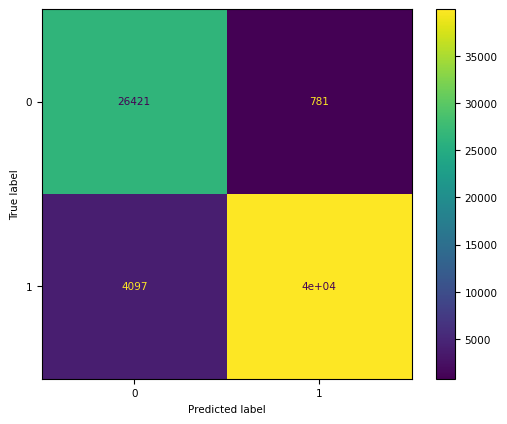

In [37]:
cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

### Tuning Model Hyperparameters

Now that we trained our model, let us try and tune its hyperparameters. Currently our model is using the default parameters for RandomForrestClassifier, with 100 estimators. We will try modifying n_estimators (number of estimators being used) and max_features (how features are selected in the estimators). We will use 5 different values for n_estimators and 2 different values for max_features.

In [38]:
print("Current Model Hyperparameters: ")
print(rf.get_params())

# Number of trees in random forest
n_estimators = [100, 150, 200, 250, 300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

Current Model Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

"""
results = []
for i in n_estimators:
    for j in max_features:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        score = f1_score(y_test, y_pred)
        print(i, j, score)
        results.append(score)

100 auto 0.9423097254690052
100 sqrt 0.9426805480482244
150 auto 0.9424385200155095
150 sqrt 0.9424355630741759
200 auto 0.9424947145877378
200 sqrt 0.942359186357871
250 auto 0.9423483531457032
250 sqrt 0.9424479870305323
300 auto 0.942420184650081
300 sqrt 0.9424990308825429

"""

'\nresults = []\nfor i in n_estimators:\n    for j in max_features:\n        rf = RandomForestClassifier()\n        rf.fit(X_train, y_train)\n        y_pred = rf.predict(X_test)\n        score = f1_score(y_test, y_pred)\n        print(i, j, score)\n        results.append(score)\n\n100 auto 0.9423097254690052\n100 sqrt 0.9426805480482244\n150 auto 0.9424385200155095\n150 sqrt 0.9424355630741759\n200 auto 0.9424947145877378\n200 sqrt 0.942359186357871\n250 auto 0.9423483531457032\n250 sqrt 0.9424479870305323\n300 auto 0.942420184650081\n300 sqrt 0.9424990308825429\n\n'

While the difference was marginal, we discovered that (n_estimators = 100, max_features = 'sqrt') is the optimal combination of hyperparameters for the parameters and values we tested. Let us retrain our model using these parameters.

In [40]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier()

### Model Validation using original data
To verify that our model and feature engineering process is accurate, we will try and preprocess and predict on our original dataset. We will use the same methodology that we did above. Any null values will be filled with the mode of the dataset. We see that on our original training dataset, we achieved an excellent F1-Score of 90.17%.

In [41]:
def preprocess(df):
    df["label"] = 123
    df = df[preprocess_columns]
    new_df = type_code(df)
    binary_cols(new_df, train_df)
    new_df = currency_code(new_df)
    new_df = contract_type(new_df)
    new_df = class_id(new_df)
    new_df = debit_code(new_df)
    new_df = branch(new_df)
    new_df = language_code(new_df)
    new_df= options_trading_type(new_df)
    deceased_fair_market_value(new_df, train_df)
    new_df = iso_funds_code(new_df)
    new_df = title(new_df)
    new_df = risk_tolerance(new_df)
    new_df = investment_objective(new_df)
    new_df = dates(new_df)
    new_df = new_df.fillna(new_df.mode().iloc[0])
    new_df = new_df.drop("label", axis=1)
    return new_df

temp_label = df["label"].apply(lambda x: 1 if x == "Churn" else 0)
validation_df = preprocess(df)
validation_df["label"] = temp_label
validation_df.head(5)


,is_registered,is_active,inception_date,include_client_consolidation,use_client_address,...,inv_S,inv_L,never_traded,last_possible_trade,label
0,0,1,736559.0,1,0,...,0.0,0.0,1,800,1
1,1,1,737006.0,1,1,...,10.0,0.0,1,600,1
2,1,1,733505.0,0,0,...,50.0,0.0,1,2060,1
3,0,1,737794.0,1,1,...,0.0,0.0,1,1146,1
4,0,1,736531.0,1,0,...,0.0,0.0,1,2406,1


In [42]:
y_pred_val = rf.predict(validation_df.drop('label', axis=1))
f1_val = f1_score(validation_df['label'], y_pred_val)
print("F1: ", f1_val)

F1:  0.9016644625187964


### Predicting on the Test Data
Finally, we will predict on our test data. We will first import it, then preprocess it, finally we will create a csv with our predictions

In [43]:
df_test = pd.read_csv("data/test.csv")
df_test_ids = df_test["id"]
df_test.head()

,id,type_code,is_registered,country_code,currency_code,...,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports
0,1155742,CASH,f,NaN,CAD,...,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t
1,1269359,TFSA,t,NaN,CAD,...,2023-08-10 21:47:25.370403+00,f,2022-10-20 00:00:00,ROMANAA,t
2,573181,CASH,f,NaN,CAD,...,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t
3,967968,TFSA,t,NaN,CAD,...,2023-08-10 21:47:25.370403+00,f,2021-08-06 00:00:00,T80,f
4,595581,CASH,f,NaN,CAD,...,2023-08-08 20:37:22.511698+00,f,NaN,NaN,t


In [44]:
df_test = preprocess(df_test)
df_test.head()

,is_registered,is_active,inception_date,include_client_consolidation,use_client_address,...,inv_I,inv_S,inv_L,never_traded,last_possible_trade
0,0,1,736531.0,1,1,...,0.0,25.0,0.0,1,2406
1,1,1,737493.0,1,1,...,0.0,0.0,100.0,1,1206
2,0,1,738530.0,1,1,...,0.0,0.0,0.0,1,410
3,1,1,736531.0,1,0,...,0.0,0.0,0.0,1,1453
4,0,1,733456.0,1,1,...,35.0,0.0,0.0,1,4712


In [45]:
df_test["label"] = rf.predict(df_test)
final_predictions = pd.DataFrame({"id": df_test_ids, "predicted": df_test["label"]})
final_predictions["predicted"] = final_predictions["predicted"].apply(lambda x: "churn" if x == 1 else "no churn")
final_predictions.head()

,id,predicted
0,1155742,churn
1,1269359,churn
2,573181,churn
3,967968,no churn
4,595581,churn


In [46]:
final_predictions.to_csv("submission.csv")

## Part 2: Developing a Marketing Strategy for our churned customers.
We will now analyze the customers who have churned to determine if there are any notable trends. With this information, we will develop some marketing strategies to help maintain our platform's growth. We will start by selecting all of the rows which have churned in our test set.

In [47]:
predictions_churn = df_test[df_test["label"] == 1]
predictions_churn.head()

,is_registered,is_active,inception_date,include_client_consolidation,use_client_address,...,inv_S,inv_L,never_traded,last_possible_trade,label
0,0,1,736531.0,1,1,...,25.0,0.0,1,2406,1
1,1,1,737493.0,1,1,...,0.0,100.0,1,1206,1
2,0,1,738530.0,1,1,...,0.0,0.0,1,410,1
4,0,1,733456.0,1,1,...,0.0,0.0,1,4712,1
6,0,1,737857.0,1,1,...,0.0,0.0,1,1083,1


While engineering our training data, we noticed that there were a lot of null values within the dataset. We hypothesized that this could be due to error or users not putting in their data when signing up. We also hypothesized that certain features, such as the trading/creation dates and the risk/security distributions could have a considerable impact on customer's uses for the platform. To determine the impact that these features could have on customer churn, we can visualize the feature importances for our Random Forrest Classifier Model.

<BarContainer object of 73 artists>

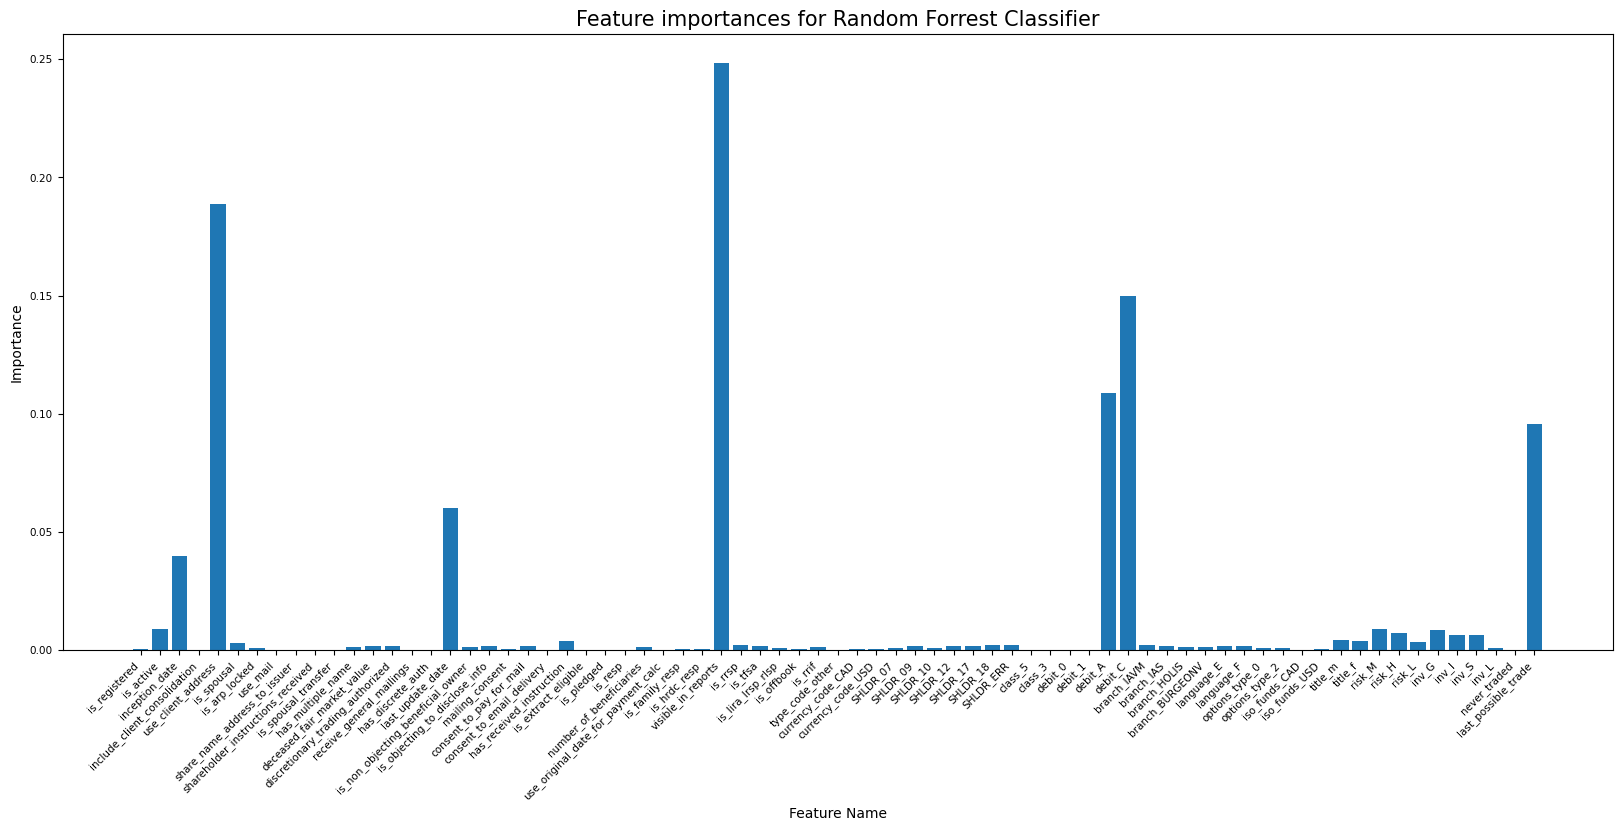

In [52]:
plt.figure(figsize=(20,8))
important_features = pd.DataFrame({"columns": step4_df.drop("label",axis=1).columns, "importance":rf.feature_importances_})
plt.rcParams['font.size'] = 7.5
plt.title("Feature importances for Random Forrest Classifier", fontsize=15)
plt.xlabel("Feature Name", fontsize=10)
plt.ylabel("Importance", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.bar(important_features["columns"],important_features["importance"])

From the above bar chart, we can clearly see that specific features had a large impact on our model. Many features revolved around when customers created, updated and traded on their accounts (last_possible_trade, last_update_date, inception_date, is_active), with other features revolving around user data seeing smaller importances. Notably, visible_in_reports and use_client_address had a significant impact on our model.

Features revolving around user's trading preferences and use cases also had a considerable impact on our model, especially debit_A and debit_C, which indicate special debit interest account types.

Due to their importance to the model, we can infer that these attributes play a considerable role in Customer churn.

### Marketing Suggestions
To ensure that the trading platform can prevent customer churn and continue their growth, we propose 3 marketing campaigns. These campaigns will be explored in more depth in the corresponding report:
- Quarterly Check-ins to update data: Ensure that customers update their data and information in a timely manner so they can trade easier on the platform. These reminders should also remind users of the platform, increasing their chances of using the platform.
- Weekly updates on finance, catered to a customer's portfolio breakdown: these will keep customers informed about their portfolio, increasing the chances that they use the platform. This update can also expose customers to different risk / investment options, allowing them to create a more customized trading portfolio.
- Online resources for risk types/security options: Having these available will ensure that customers can confidently set up their profiles and invest with the platform. Additionally, SEO could result in non-customers discovering the webpage and potentially joining the platform, increasing the userbase and the platform's exposure.

## Part 3: Next Steps
To improve this model and its development process, we identified three areas of improvement:
1. Handling null values: when processing the data, many null values were replaced with the mode in the column. While this could work in some cases,  it can also result in unrealistic customer profiles. In the future, we could implement separate models to predict these features
2. Model selection: we only explored the Random Forrest Classification model, exploring different types of models such as decision trees, logistic regression, neural networks, etc. could improve model performance.
3. Hyperparameter tuning: due to computational power, we were not able to explore a large range of values for our hyperparameters, resulting in minimal improvements. By having more computational power, we can leverage GridSearchCV and RandomSearchCV to explore more features.